In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import cv2

from utils import get_calibration_mat, get_best_match, load_dataset

In [7]:
train = pd.read_csv('../train.csv', index_col = 'id')
PATH = './Dataset/train/'
JPG = '.jpg'

In [3]:
# initialise camera matrix
H_FoV = 73.7
V_FoV = 53.1

W = 680
H = 490

K = get_calibration_mat(H_FoV, V_FoV, W, H)

In [10]:
img1_name = 'IMG3073_5'

# load image
img1 = cv2.imread(PATH + img1_name + JPG, 0)

# load features
feat, no_feat = load_dataset('training_set')
_ = feat.pop(img1_name)

In [11]:
img2_name, good_matches, [kp_q, kp_m] = get_best_match(img1, feat, no_feat)

pts_q = np.float32([kp_q[pt.queryIdx].pt for pt in good_matches]).reshape(-1,1,2)
pts_m = np.float32([kp_m[pt.trainIdx].pt for pt in good_matches]).reshape(-1,1,2)

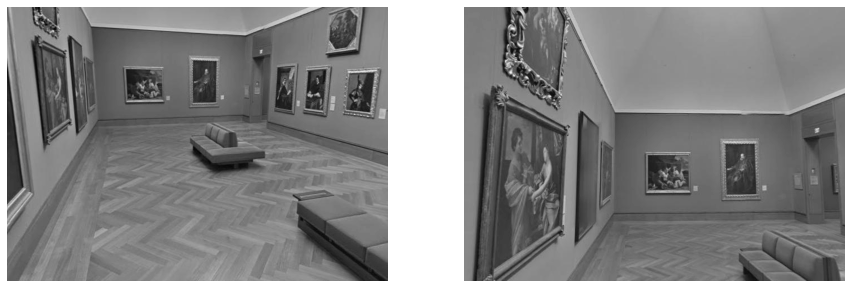

In [13]:
img2 = cv2.imread(PATH + img2_name + JPG, 0)
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img1, cmap = 'gray')

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(img2, cmap = "gray")
plt.show()

In [15]:
# translation between the 2 images
(x1, y1), (x2, y2) = train.loc[img1_name], train.loc[img2_name]

In [16]:
x1, y1, x2, y2

(30.91932192, 4.282719649, 33.21932192, 5.58271965)

Obtain $R$, $T$ using essential matrix

In [17]:
E, _ = cv2.findEssentialMat(pts_q, pts_m, K)

In [32]:
_, R1, t1, _ = cv2.recoverPose(E, pts_q, pts_m, K)

In [19]:
R1

array([[ 0.97320385, -0.05117557,  0.22417699],
       [-0.02032513,  0.95195872,  0.30555112],
       [-0.229044  , -0.30191995,  0.92540974]])

In [33]:
t1

array([[ 0.05481213],
       [-0.0886975 ],
       [-0.99454934]])

In [89]:
scale_x1 = (x1 - x2) / t1[0]
scale_x1

array([-41.96151376])

In [90]:
scale_y1 = (y1 - y2) / t1[1]
scale_y1

array([14.65655703])

Obtain $R$, $T$ using fundamental matrix

In [21]:
F, _ = cv2.findFundamentalMat(pts_q, pts_m, cv2.FM_8POINT)

In [22]:
_, R2, t2, _ = cv2.recoverPose(K.T @ F @ K, pts_q, pts_m, K)

In [23]:
R2

array([[ 0.93516343, -0.0254298 , -0.35330255],
       [ 0.05058906,  0.99678331,  0.06215931],
       [ 0.35058538, -0.07600236,  0.93344177]])

In [24]:
t2

array([[0.91919579],
       [0.38425048],
       [0.0862013 ]])

In [91]:
scale_x2 = (x1 - x2) / t2[0]
scale_x2

array([-2.50218726])

In [92]:
scale_y2 = (y1 - y2) / t2[1]
scale_y2

array([-3.38320986])

### find a 3rd image for testing

In [43]:
feat.pop(img2_name)

img3_name, good_matches, [kp_q, kp_m] = get_best_match(img1, feat, no_feat)

pts_q = np.float32([kp_q[pt.queryIdx].pt for pt in good_matches]).reshape(-1,1,2)
pts_m = np.float32([kp_m[pt.trainIdx].pt for pt in good_matches]).reshape(-1,1,2)

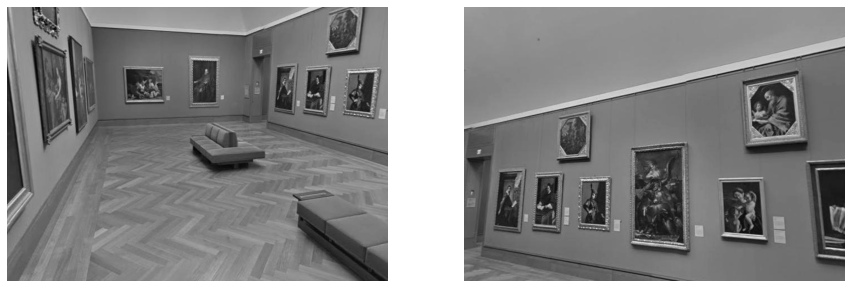

In [46]:
img3 = cv2.imread(PATH + img3_name + JPG, 0)
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img1, cmap = 'gray')

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(img3, cmap = "gray")
plt.show()

In [44]:
_, R3, t3, _ = cv2.recoverPose(E, pts_q, pts_m, K)
_, R4, t4, _ = cv2.recoverPose(K.T @ F @ K, pts_q, pts_m, K)

In [70]:
# actual location of test img
(x3, y3) = train.loc[img3_name]
x3, y3

(33.01932192, 3.88271965)

In [93]:
xtest1 = x1  + t3[0] * scale_x1
ytest1 = y1 + t3[1] * scale_y1

In [94]:
# location of test img using E
xtest1, ytest1

(array([33.21932192]), array([5.58271965]))

In [95]:
xtest2 = x1 + t4[0] * scale_x2
ytest2 = y1 + t4[1] * scale_y2

In [96]:
xtest2, ytest2

(array([33.21932192]), array([5.58271965]))

In [97]:
np.abs(x3 - xtest1) + np.abs(y3 - ytest1)

array([1.9])